**<h1>Identifying Inappropriate Table of Surgical Procedures (TOSP) Pair Codes with DBSCAN</h1>**


<p align="justify">
In this notebook, we continue our analysis from the previous KMeans clustering approach and explore DBSCAN as an alternative method for grouping TOSP code descriptions (also covered in week 08). Our previous findings indicated that KMeans struggled to effectively capture the nuanced relationships between procedure descriptions, often resulting in poorly separated clusters and misgrouped codes.

<p align="justify">
Here, we assess whether DBSCAN, a density-based clustering algorithm, can provide more meaningful groupings by identifying natural clusters in the data. We focus on tuning key DBSCAN parameters such as epsilon (ε) and min_samples to optimize clustering performance. Evaluation metrics including Davies-Bouldin Score, Silhouette Score and Calinski-Harabasz Index will be used to determine whether DBSCAN offers improvements over KMeans in identifying inappropriate TOSP code pairs.

---

## **1. Import Libraries and Setup**

Import the necessary libraries to set up the notebook.

In [1]:
# Import the required libraries
import re
import nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Download Natural Language Toolkit (NLTK)
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **2. Data Loading and Pre-processing (Same procedure as KMeans)**

Loading the TOSP dataset (combined_dataset.csv) and applying the following pre-processing steps to enhance text quality:

* Convert text to lowercase - standardises input
* Removes numbers and punctuation reduces noise
* Removes stopwords - eliminates common but unimportant words
* Apply lemmatisation - reduces words to their base form for better clustering
* Trim extra spaces - removing unintended multiple spaces

<p align="justify">After preprocessing, we use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the cleaned descriptions into numerical representations. This technique assigns higher weights to important words determined by term frequency (TF) — <i>How many times does this word appear in this document among the number of times all words appear in this document? and <i>Inverse Document Frequency (IDF) — <i>How common (or uncommon) is this word among all the documents I have?</i>

---

In [2]:
# Loading the data (combined_dataset.csv)
df_tosp = pd.read_csv("combined_dataset.csv")

# Data pre-processing
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    words = text.split()

    # Remove stopwords first
    words = [word for word in words if word not in stop_words]

    # Lemmatization after stopword removal
    words = [lemmatizer.lemmatize(word) for word in words]

    # Trim extra spaces
    return " ".join(words).strip()

df_tosp["Cleaned_Description"] = df_tosp["Description"].apply(preprocess_text)

# Display first 3 samples of the processed descriptions
print("\nSample of cleaned descriptions:")
for i, text in enumerate(df_tosp["Cleaned_Description"].head(3)):
    print(f"Original: {df_tosp['Description'].iloc[i][:100]}...")
    print(f"Cleaned: {text[:100]}...")
    print("-" * 50)


Sample of cleaned descriptions:
Original: BOTULINUM TOXIN THERAPY FOR MOVEMENT DISORDERS...
Cleaned: botulinum toxin therapy movement disorder...
--------------------------------------------------
Original: BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILATERAL)...
Cleaned: breast ductal lesion microdochectomy bilateral...
--------------------------------------------------
Original: BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILATERAL)...
Cleaned: breast ductal lesion microdochectomy unilateral...
--------------------------------------------------


In [3]:
# Extract descriptions and vectorize them using TF‑IDF
descriptions = df_tosp["Cleaned_Description"].tolist()
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(descriptions)

## **3. Finding the best Epsilon and epsilon (ε) and min_samples for DBSCAN with Grid Search and Silhouette Analysis**

<p align="justify">
In this section, we aim to determine the best epsilon (ε) and min_samples values for DBSCAN clustering by leveraging grid search and evaluating results using the silhouette score, Davies-Bouldin Index and Calinski-Harabasz Index.

<p align="justify">
Since the ground truth labels for clustering are unknown, are appropriate to assess the clustering performance

| **Metric**                 | **High Value Means**         | **Low Value Means**        | **Best For**                    |
|----------------------------|-----------------------------|----------------------------|----------------------------------|
| **Silhouette Score**       | Well-separated clusters     | Overlapping clusters       | General clustering quality      |
| **Calinski-Harabasz Index**| Compact, distinct clusters  | Poorly defined clusters    | Evaluating compactness          |
| **Davies-Bouldin Index**   | Poor clustering            | Well-separated clusters    | Detecting cluster overlap       |

References:

[[Clustering performance evaluation [scikit-learn]](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)

[[How to measure clustering performances when there are no ground truth? by Haitian Wei - Medium]](https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c)

---

In [4]:
# Define range for DBSCAN parameters
eps_range = np.linspace(0.1, 1.0, 10)
min_samples_range = range(3, 10)

# Initialize matrices for storing clustering scores
silhouette_data = np.full((len(min_samples_range), len(eps_range)), np.nan)
dbi_data = np.full((len(min_samples_range), len(eps_range)), np.nan)
chs_data = np.full((len(min_samples_range), len(eps_range)), np.nan)

# Store best scores and corresponding parameters
best_silhouette = {"score": -1, "eps": None, "min_samples": None}
best_dbi = {"score": float("inf"), "eps": None, "min_samples": None}
best_chs = {"score": -1, "eps": None, "min_samples": None}

# Perform Grid Search over DBSCAN hyperparameters
for i, min_samples in enumerate(min_samples_range):
    for j, eps in enumerate(eps_range):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
        labels = dbscan.fit_predict(X)

        # Check if clustering produced meaningful clusters (at least 2 clusters excluding noise)
        mask = labels != -1  # Remove noise points
        unique_labels_non_noise = np.unique(labels[mask])
        if len(unique_labels_non_noise) < 2 or np.sum(mask) < 2:
            continue  # Skip evaluation for this configuration

        try:
            # Compute clustering metrics
            silhouette = silhouette_score(X[mask], labels[mask], metric="cosine")
            dbi = davies_bouldin_score(X[mask].toarray(), labels[mask])
            chs = calinski_harabasz_score(X[mask].toarray(), labels[mask])

            # Store results in matrices
            silhouette_data[i, j] = silhouette
            dbi_data[i, j] = dbi
            chs_data[i, j] = chs

            # Print each result
            print(f"eps: {eps:.2f}, min_samples: {min_samples}, silhouette score: {silhouette:.4f}, DBI: {dbi:.4f}, CHI: {chs:.4f}")

            # Update best scores
            if silhouette > best_silhouette["score"]:
                best_silhouette.update({"score": silhouette, "eps": eps, "min_samples": min_samples})

            if dbi < best_dbi["score"]:  # Lower is better
                best_dbi.update({"score": dbi, "eps": eps, "min_samples": min_samples})

            if chs > best_chs["score"]:
                best_chs.update({"score": chs, "eps": eps, "min_samples": min_samples})

        except Exception as e:
            print(f"Error for eps={eps:.2f}, min_samples={min_samples}: {e}")

# Print best parameters for each metric
print("\nBest Parameters:")
print(f"Silhouette Score: Best eps={best_silhouette['eps']:.2f}, min_samples={best_silhouette['min_samples']} with score={best_silhouette['score']:.6f} (higher is better)")
print(f"Davies-Bouldin Index: Best eps={best_dbi['eps']:.2f}, min_samples={best_dbi['min_samples']} with score={best_dbi['score']:.6f} (lower is better)")
print(f"Calinski-Harabasz Index: Best eps={best_chs['eps']:.2f}, min_samples={best_chs['min_samples']} with score={best_chs['score']:.6f} (higher is better)")

eps: 0.10, min_samples: 3, silhouette score: 0.9419, DBI: 0.3270, CHI: 68.6405
eps: 0.20, min_samples: 3, silhouette score: 0.8047, DBI: 0.6217, CHI: 24.6037
eps: 0.30, min_samples: 3, silhouette score: 0.6342, DBI: 0.9843, CHI: 13.0468
eps: 0.40, min_samples: 3, silhouette score: 0.4868, DBI: 1.2376, CHI: 9.1119
eps: 0.50, min_samples: 3, silhouette score: 0.2270, DBI: 1.9208, CHI: 5.2568
eps: 0.60, min_samples: 3, silhouette score: 0.0212, DBI: 2.0814, CHI: 3.5148
eps: 0.70, min_samples: 3, silhouette score: -0.0301, DBI: 1.8297, CHI: 2.4773
eps: 0.80, min_samples: 3, silhouette score: 0.0075, DBI: 0.9932, CHI: 3.0384
eps: 0.10, min_samples: 4, silhouette score: 0.9514, DBI: 0.3040, CHI: 97.2935
eps: 0.20, min_samples: 4, silhouette score: 0.8236, DBI: 0.5914, CHI: 32.9672
eps: 0.30, min_samples: 4, silhouette score: 0.6633, DBI: 0.9717, CHI: 16.1332
eps: 0.40, min_samples: 4, silhouette score: 0.4866, DBI: 1.2660, CHI: 10.5107
eps: 0.50, min_samples: 4, silhouette score: 0.2212, DBI

<p align="justify">
We have selected Silhouette Score as the primary evaluation metric because it provides a balanced measure of both cluster cohesion (how close points within the same cluster are) and cluster separation (how distinct clusters are from each other).

<p align="justify">
The evaluation results suggest that eps = 0.10 and min_samples = 4 or 5 provide the best clustering performance across different metrics.

## **Plotting The Results on a Heatmap**

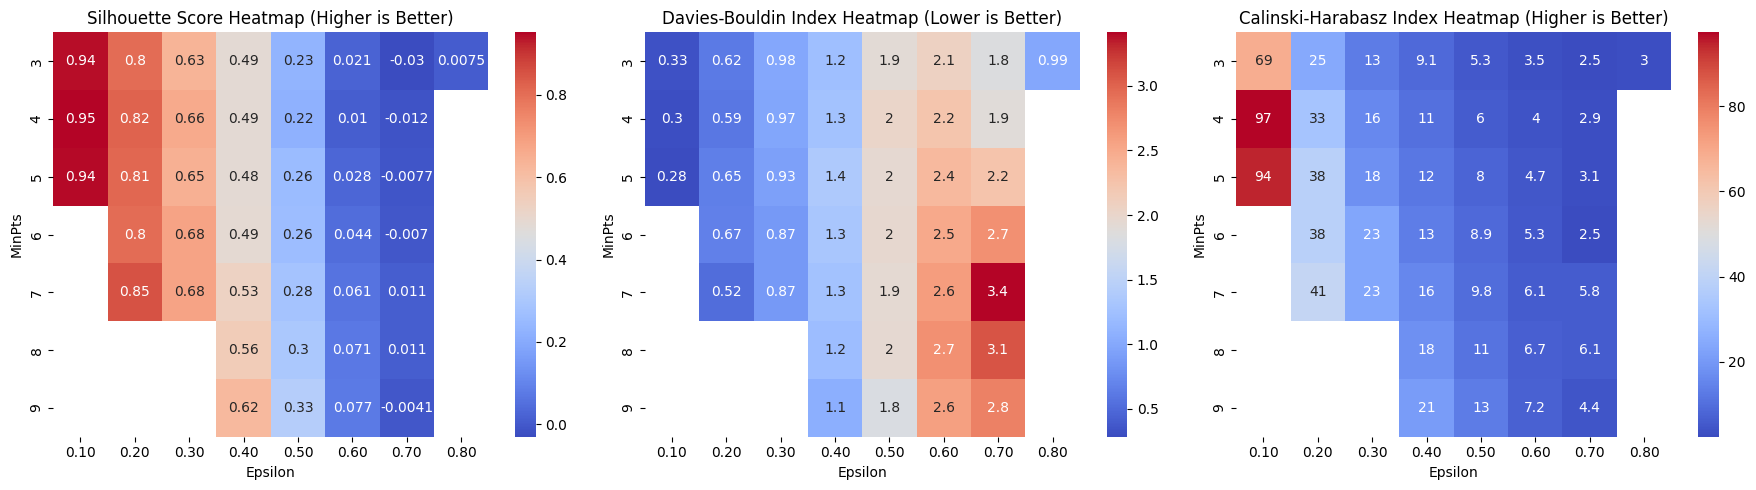

In [5]:
# Remove specified eps = 0.90 and 1.00 as it is empty
remove_eps_values = [0.90, 1.00]
indices_to_keep = [i for i, eps in enumerate(eps_range) if eps not in remove_eps_values]

# Filter out these columns from the matrices
filtered_silhouette_data = silhouette_data[:, indices_to_keep]
filtered_dbi_data = dbi_data[:, indices_to_keep]
filtered_chs_data = chs_data[:, indices_to_keep]

# Update eps_range for the heatmap
filtered_eps_range = [eps_range[i] for i in indices_to_keep]

# Round epsilon values to 2 decimal places
formatted_eps_range = [f"{eps:.2f}" for eps in filtered_eps_range]

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score Heatmap
sns.heatmap(filtered_silhouette_data, annot=True, cmap="coolwarm", xticklabels=formatted_eps_range, yticklabels=min_samples_range, ax=axes[0])
axes[0].set_title("Silhouette Score Heatmap (Higher is Better)")
axes[0].set_xlabel("Epsilon")
axes[0].set_ylabel("MinPts")

# Davies-Bouldin Index Heatmap
sns.heatmap(filtered_dbi_data, annot=True, cmap="coolwarm", xticklabels=formatted_eps_range, yticklabels=min_samples_range, ax=axes[1])
axes[1].set_title("Davies-Bouldin Index Heatmap (Lower is Better)")
axes[1].set_xlabel("Epsilon")
axes[1].set_ylabel("MinPts")

# Calinski-Harabasz Index Heatmap
sns.heatmap(filtered_chs_data, annot=True, cmap="coolwarm", xticklabels=formatted_eps_range, yticklabels=min_samples_range, ax=axes[2])
axes[2].set_title("Calinski-Harabasz Index Heatmap (Higher is Better)")
axes[2].set_xlabel("Epsilon")
axes[2].set_ylabel("MinPts")

plt.tight_layout()
plt.show()

**Short Analysis on Clustering Performance Evaluation**

<p align="justify">
The grid search suggested that the optimal parameters are {'eps': 0.10, 'min_samples': 4}, with a high Silhouette Score of 0.9514. This suggests that the clusters formed are well-defined, with high intra-cluster similarity and clear separation between different clusters.

<p align="justify">
However, while a very low epsilon (eps = 0.10) provides high precision in cluster formation, it might also indicate that the clusters are overly fine-grained, potentially isolating points rather than grouping them in a meaningful way. Even from limited medical domain knowledge, we can observe that a cluster should only contain 2-3 TOSP codes. The slight difference between the optimal min_samples suggests that careful tuning is required to balance meaningful grouping with avoiding excessive fragmentation.


## **4. Training the DBSCAN model and comparing TOSP Code Pairs**

<p align = "justify">
The DBSCAN model was trained using the optimal parameters identified in our analysis. Since we do not have access to medical professionals for validation, our evaluation relies on manual inspection. Specifically, we assess similarity by identifying repeated keywords—such as "cataract surgery"—in the TOSP code descriptions to determine whether code pairs should be considered similar or different.

We will train three DBSCAN models with slightly variying parameters:

In [6]:
# Training DBSCAN Clustering (Model 1: eps = 0.1, min_samples = 4)
# Based on Silhoutte Score and Calinski-Harabasz Index
dbscan_1 = DBSCAN(eps=0.1, min_samples=4, metric="cosine")
dbscan_labels_1 = dbscan_1.fit_predict(X)

# Training DBSCAN Clustering (Model 2: eps = 0.1, min_samples = 5)
# Based on avies-Bouldin Index
dbscan_2 = DBSCAN(eps=0.2, min_samples=5, metric="cosine")
dbscan_labels_2 = dbscan_2.fit_predict(X)

# Training DBSCAN Clustering (Model 3: eps = 0.2, min_samples = 4)
# Increasing eps by 0.1 to see the difference vs. model 1
dbscan_3 = DBSCAN(eps=0.2, min_samples=5, metric="cosine")
dbscan_labels_3 = dbscan_3.fit_predict(X)

# Assign cluster labels to the dataframe
df_tosp["DBSCAN_Label_1"] = dbscan_labels_1  # Model 1 labels
df_tosp["DBSCAN_Label_2"] = dbscan_labels_2  # Model 2 labels
df_tosp["DBSCAN_Label_3"] = dbscan_labels_3  # Model 3 labels

# Defining a function to test a pair of codes
def test_code_pair(code1, code2, df, vectorizer):
    # Locate the indices of the provided codes
    idx1_list = df.index[df["Code"] == code1].tolist()
    idx2_list = df.index[df["Code"] == code2].tolist()

    if not idx1_list or not idx2_list:
        print(f"One or both codes ({code1}, {code2}) were not found.")
        return

    idx1 = idx1_list[0]
    idx2 = idx2_list[0]

    # Retrieve the TOSP code descriptions
    desc1 = df.loc[idx1, "Description"]
    desc2 = df.loc[idx2, "Description"]

    # Get cluster labels from both DBSCAN models
    dbscan_label1_model1 = df.loc[idx1, "DBSCAN_Label_1"]
    dbscan_label2_model1 = df.loc[idx2, "DBSCAN_Label_1"]
    dbscan_label1_model2 = df.loc[idx1, "DBSCAN_Label_2"]
    dbscan_label2_model2 = df.loc[idx2, "DBSCAN_Label_2"]
    dbscan_label1_model3 = df.loc[idx1, "DBSCAN_Label_3"]
    dbscan_label2_model3 = df.loc[idx2, "DBSCAN_Label_3"]

    same_dbscan_model1 = (dbscan_label1_model1 == dbscan_label2_model1)
    same_dbscan_model2 = (dbscan_label1_model2 == dbscan_label2_model2)
    same_dbscan_model3 = (dbscan_label1_model3 == dbscan_label2_model3)

    # Compute cosine similarity using TF‑IDF vectors
    vec1 = vectorizer.transform([desc1])
    vec2 = vectorizer.transform([desc2])
    cos_sim = cosine_similarity(vec1, vec2)[0][0]

    # Output the results
    print(f"Comparing code pair: {code1} vs {code2}")
    print(f"DBSCAN model 1 (eps=0.1, min_samples=4)  -> {code1} in cluster {dbscan_label1_model1}, {code2} in cluster {dbscan_label2_model1}. Same cluster: {same_dbscan_model1}")
    print(f"DBSCAN model 2 (eps=0.1, min_samples=5)  -> {code1} in cluster {dbscan_label1_model2}, {code2} in cluster {dbscan_label2_model2}. Same cluster: {same_dbscan_model2}")
    print(f"DBSCAN model 3 (eps=0.2, min_samples=4)  -> {code1} in cluster {dbscan_label1_model3}, {code2} in cluster {dbscan_label2_model3}. Same cluster: {same_dbscan_model3}")
    print(f"Cosine similarity (TF‑IDF): {cos_sim:.4f}")

# Test the function with a specific pair of codes
# Example #1: Similar codes (SL701L vs SL702L)
test_code_pair("SL701L", "SL702L", df_tosp, vectorizer)

print()

# Example #2: Different codes (SL702L vs SL705O)
test_code_pair("SL701L", "SL705O", df_tosp, vectorizer)

Comparing code pair: SL701L vs SL702L
DBSCAN model 1 (eps=0.1, min_samples=4)  -> SL701L in cluster -1, SL702L in cluster -1. Same cluster: True
DBSCAN model 2 (eps=0.1, min_samples=5)  -> SL701L in cluster -1, SL702L in cluster -1. Same cluster: True
DBSCAN model 3 (eps=0.2, min_samples=4)  -> SL701L in cluster -1, SL702L in cluster -1. Same cluster: True
Cosine similarity (TF‑IDF): 0.9597

Comparing code pair: SL701L vs SL705O
DBSCAN model 1 (eps=0.1, min_samples=4)  -> SL701L in cluster -1, SL705O in cluster -1. Same cluster: True
DBSCAN model 2 (eps=0.1, min_samples=5)  -> SL701L in cluster -1, SL705O in cluster -1. Same cluster: True
DBSCAN model 3 (eps=0.2, min_samples=4)  -> SL701L in cluster -1, SL705O in cluster -1. Same cluster: True
Cosine similarity (TF‑IDF): 0.0000


## **5. Saving the DBSCAN Model**

<p align="justify">
To avoid retraining, we save the trained DBSCAM model using joblib. This allows us to reuse them later without recomputing clusters.

Since all of the models performed similarly poorly, we will just save the first model.

In [7]:
import joblib

# Save DBSCAN model
joblib.dump(dbscan_1, "DBSCAN_Model.pkl")

print("DBSCAN Clustering Model saved successfully!")

DBSCAN Clustering Model saved successfully!


## **6. Conclusion and Recommendations**

<p align = "justify">
Our testing reveals that DBSCAN, when applied to TF‑IDF representations of TOSP code descriptions, does not yield a satisfactory clustering solution for identifying inappropriate code pairs. While DBSCAN initially produced a high silhouette score (0.9514), this metric is misleading in this context because it does not account for the fact that a significant portion of data points are classified as noise.

<p align = "justify">
For example, all tested codes (e.g., SL701L, SL702L, SL705O) were assigned a noise label (-1), indicating that DBSCAN failed to cluster them effectively. Even though some codes had high cosine similarity (suggesting they should belong to the same cluster), DBSCAN categorised them as noise, highlighting the model’s inability to form meaningful groupings.

<p align = "justify">
DBSCAN's reliance on a low ε (0.1) has resulted in over-fragmentation, where only a subset of data points forms tight clusters while the majority is discarded as noise. As a result, DBSCAN’s performance is worse than KMeans in this scenario, as it does not provide a useful clustering structure for domain-specific analysis.

<p align = "justify">
To improve performance, alternative approaches could be considered, such as:

* Exploring alternative clustering techniques, such as hierarchical clustering or Gaussian Mixture Models (GMM).

* Incorporating domain-specific embeddings instead of TF-IDF to capture semantic relationships more effectively.

In the next notebook, we will explore Agglomerative Clustering, a type of hierarchical clustering that provide better results as it does not require a predefined number of clusters and avoids excessive noise labeling.

---
